In [263]:
import networkx as nx
# https://networkx.github.io/documentation/stable/reference/index.html
import matplotlib.pyplot as plt
from matplotlib import pylab
import numpy as np
import pandas as pd

In [264]:
nx.__version__

'3.1'

# Exploration of the graph : relational data understanding

In [265]:
# load the graph
# The graph is an extraction from LinkedIn Social Network
G = nx.read_gexf("mediumLinkedin.gexf")

In [266]:
print(G)

Graph with 811 nodes and 1597 edges


In [267]:
G.number_of_nodes()

811

In [268]:
# Nb of edges
G.number_of_edges()

1597

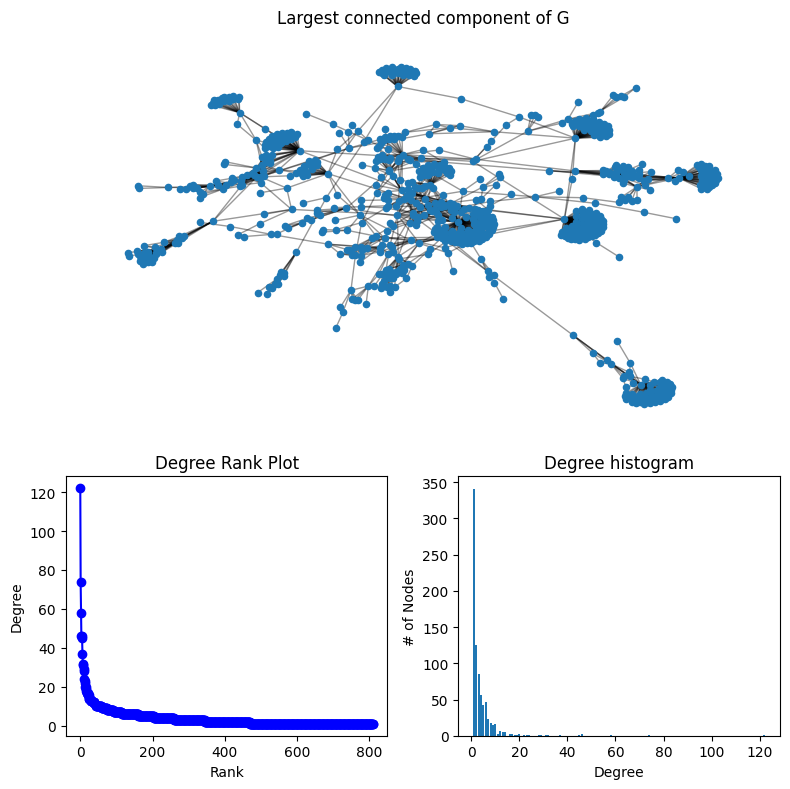

In [269]:
degree_sequence = sorted((d for n, d in G.degree()), reverse=True)

dmax = max(degree_sequence)

fig = plt.figure("Degree of a random graph", figsize=(8, 8))
# Create a gridspec for adding subplots of different sizes
axgrid = fig.add_gridspec(5, 4)

ax0 = fig.add_subplot(axgrid[0:3, :])
Gcc = G.subgraph(sorted(nx.connected_components(G), key=len, reverse=True)[0])
pos = nx.spring_layout(Gcc, seed=10396953)
nx.draw_networkx_nodes(Gcc, pos, ax=ax0, node_size=20)
nx.draw_networkx_edges(Gcc, pos, ax=ax0, alpha=0.4)
ax0.set_title("Largest connected component of G")
ax0.set_axis_off()

ax1 = fig.add_subplot(axgrid[3:, :2])
ax1.plot(degree_sequence, "b-", marker="o")
ax1.set_title("Degree Rank Plot")
ax1.set_ylabel("Degree")
ax1.set_xlabel("Rank")

ax2 = fig.add_subplot(axgrid[3:, 2:])
ax2.bar(*np.unique(degree_sequence, return_counts=True))
ax2.set_title("Degree histogram")
ax2.set_xlabel("Degree")
ax2.set_ylabel("# of Nodes")

fig.tight_layout()
plt.show()

# Profil data understanding

In [270]:
# We use pandas dataframes to load attributes
# Nodes are characterized by a list of colleges, a list of employers, a list of location
# The order means nothing. Nothing allow us to determine the current employer...
df_e = pd.read_csv('employer_with_60percent_of_nodes_remoded.csv', sep='\t', header='infer')
df_e.head()

,name,employer
0,U1313,discovery education
1,U1313,ctb mcgraw-hill
2,U1313,university of charleston university of south c...
3,U1313,south carolina department of education
4,U1313,chesapeake va and sumter sc


In [271]:
df_e.groupby('name').count().describe()

,employer
count,297.000000
mean,3.107744
std,1.976682
min,1.000000
25%,1.000000
50%,3.000000
75%,4.000000
max,13.000000


In [272]:
df_e['employer'].value_counts()

university of illinois at urbana-champaign    76
google                                        15
microsoft                                     15
university of texas at austin                  5
amazon                                         5
                                              ..
new jersey department of education             1
brookings institution                          1
syrian emergency task force (setf)             1
muslim public affairs council                  1
yuhuan taijie hardware co. ltd.                1
Name: employer, Length: 723, dtype: int64

In [273]:
# Boolean row selection by values in a column
df_e.loc[df_e['employer'].isin(['google','google inc']),:].head()


,name,employer
30,U3895,google
126,U15289,google
136,U24080,google
145,U24046,google
161,U7151,google


## Now, your turn!

Modify the previous cells, create your own noes to explore the dataset, and go on with the challenge. You need to understand how attributes are spread avor the nodes, as your first intuition is that neighbors tend to be similar. As you know "Birds of a feather flock together" (homophily theory in social network analysis).

Test here the homophily in the graph for each attribute


# We provide the baseline method to fill empty profiles, a naive implementation of the homophily theory

The assumption is that two connected nodes are likely to share the same attribute values. Here we choose the most frequently used attribute value among the neighbors.

Baseline method means that you will compare your own method with this one. Your job is to improve the quality of attribute predition. We will measure that in terms of precision.

In [274]:
naive_predicted_values={}

In [275]:
# Get a list from a Series
filled_nodes = df_e['name'].drop_duplicates().tolist()
print(f'{len(filled_nodes)*100/G.number_of_nodes():.2f} % of nodes have attributes (here employer attribute)')


36.62 % of nodes have attributes (here employer attribute)


In [276]:
#list difference, need the function `set()` to create sets ;-)
empty=set(G.nodes())-set(filled_nodes)
print(f'{len(empty)} empty nodes, without any attributes')

514 empty nodes, without any attributes


In [277]:
from collections import Counter

def naive_method(graph, empty, df):
    """   Predict the missing attribute with a simple but effective
    relational classifier. 
    
    The assumption is that two connected nodes are 
    likely to share the same attribute value. Here we chose the most frequently
    used attribute by the neighbors
    
    Parameters
    ----------
    graph : graph
       A networkx graph
    empty : list
       The nodes with empty attributes 
    df : pandas dataframe 
       Either location, employer or college dataframe. 

    Returns
    -------
    predicted_values : dict 
       A dict of attributes, either location, employer or college attributes. 
       key is a node (from empty), value is a list of attribute values. Here 
       only 1 value in the list.
     """
    predicted_values={}
    for n in empty:
        nbrs_attr_values=[] 
        for node in graph.neighbors(n):
            # attribute values for the node node
            attr = df_e.loc[df_e.name == node ,'employer'].values
            if attr.size > 0: #array not empty
                for val in attr:
                    nbrs_attr_values.append(val)
        predicted_values[n]=[]
        if nbrs_attr_values: # non empty list
            # count the number of occurrence each value and returns a dict
            cpt=Counter(nbrs_attr_values)
            # take the most represented attribute value among neighbors
            a,nb_occurrence=max(cpt.items(), key=lambda t: t[1])
            predicted_values[n].append(a)
    return predicted_values


In [288]:
naive_predicted_values = naive_method(G, empty, df_e)
print(naive_predicted_values)

{'U24259': [], 'U9122': ['university of illinois at urbana-champaign'], 'U27600': ['university of delaware'], 'U7113': [], 'U8298': [], 'U19896': [], 'U4586': ['university of illinois at urbana-champaign'], 'U27515': ['google'], 'U14526': ['northern illinois university'], 'U15946': ['boston consulting group'], 'U27777': [], 'U2625': ['university of texas at austin'], 'U1134': ['measured progress'], 'U16152': ['pwc'], 'U21443': [], 'U27498': [], 'U24139': ['viasat'], 'U7989': [], 'U7260': [], 'U5996': ['sony biotechnology inc.'], 'U27687': [], 'U16078': ['cummins inc.'], 'U18588': [], 'U21094': ['university of illinois at urbana-champaign'], 'U24154': [], 'U24132': [], 'U3955': ['microsoft'], 'U24165': [], 'U27614': ['university of texas at austin'], 'U11558': ['vertica systems an hp company'], 'U7104': [], 'U8702': ['university of illinois at urbana-champaign'], 'U14566': ['merge llc'], 'U16167': [], 'U18543': [], 'U1331': ['measured progress'], 'U27738': [], 'U7380': [], 'U4456': ['un

# Evaluation: let's assess the accuracy of our method

We need to compare the predicted attributes to the groundtruth, i.e. the expected attributes

In [279]:
df_e_truth = pd.read_csv('./groundtruth/employer.csv', sep='\t', header='infer')
df_e_truth.head()

,name,employer
0,U21998,illinois college advising corps
1,U21998,victoria amplifiers
2,U21998,university of illinois at chicago
3,U27476,ibm
4,U27476,nyse euronext


In [280]:
def evaluation_accuracy(groundtruth, pred):
    """    Compute the accuracy of your model.

     The accuracy is the proportion of true results.

    Parameters
    ----------
    groundtruth : pandas dataframe 
       Either location, employer or college dataframe. 
    pred : dict 
       A dict of attributes, either location, employer or college attributes. 
       key is a node, value is a list of attribute values. 

    Returns
    -------
    out : float
       Accuracy.
    """
    true_positive_prediction=0
    predicted=0
    for p_key, p_value in pred.items():
        attr = groundtruth.loc[groundtruth.name == p_key ,groundtruth.columns[1]].values
        # if prediction is empty, e.g. [], and so is the groundtruth
        # May happen, we count it as a true prediction
        if not p_value and attr.size == 0:
            true_positive_prediction+=1
            predicted+=1
        # counts the number of good prediction for node p_key
        # here len(p_value)=1 but we could have tried to predict more values
        # if p_value == [], we add 0
        true_positive_prediction += len([c for c in p_value if c in attr])
        predicted += len([c for c in p_value])
    return true_positive_prediction*100/predicted
 

In [281]:
result=evaluation_accuracy(df_e_truth, naive_predicted_values)
print("%f%% of the predictions are true" % result)
print("Very poor result!!! Try to do better!!!!")

32.02416918429003
32.024169% of the predictions are true
Very poor result!!! Try to do better!!!!


## Now, your turn!

Provide here new strategies to fill the profiles and compare with the baseline

# Accuracy Definitions : 

## First definition : 

The first definition of the accuracy is based on the number of good prediciton over all the predictions.

From a mathematical point of view, we could represent it like this : 
\begin{equation*}
\text{Accuracy} = \frac{\text{Number of correct predictions}}{\text{Total number of predictions}}
\end{equation*}

In [282]:
def accuracy_good_predictions_over_number_of_predictions(groundtruth, predictions):
    true_positive_prediction = 0
    predicted_values = 0 
    for name, value in predictions.items():
        groundtruth_values = groundtruth.loc[groundtruth.name == name, groundtruth.columns[1]].values
        if not value and groundtruth_values.size == 0:
            true_positive_prediction += 1
            predicted_values += 1
        true_positive_prediction += len([item for item in value if item in groundtruth_values])
        predicted_values += len([item for item in value])
    return true_positive_prediction*100/predicted_values

## Second definition :

The second definition of the accuracy is based on the number of good values recovered compared to the groundtruth. 

From a mathematical point of view, we could represent it like this : 

\begin{equation*}
\text{Accuracy} = \frac{\text{Number of correct values recovered}}{\text{Total number of expected values in ground truth}}
\end{equation*}

In [283]:
def accuracy_correct_predictions_over_expected_number_of_predictions(groundtruth, predictions):
    true_positive_prediction = 0
    expected_predictions = 0 
    for name, value in predictions.items():
        groundtruth_values = groundtruth.loc[groundtruth.name == name, groundtruth.columns[1]].values
        if not value and groundtruth_values.size == 0:
            true_positive_prediction += 1
        true_positive_prediction += len([item for item in value if item in groundtruth_values])
        expected_predictions += len(groundtruth_values)
    return true_positive_prediction*100/expected_predictions    

# Strategy Number 1 : Predict college based on college of the majority of neighbors

## Example : 

If you have two neighbors with the IMT College and one with the centrale Nantes college, then you predict that the college of the last person will be IMT.

### Implementation of the method : 

In [284]:
def predict_college_from_first_neighbors(graph, empty_nodes, current_knowledge):
    predicted_value = {}
    for node in empty_nodes:
        college_counter = {}
        for neighbor in graph.neighbors(node):
            neighbor_row = current_knowledge.loc[current_knowledge['name'] == neighbor]
            if not neighbor_row.empty:
                college = neighbor_row.iloc[0]['college']
                if college in college_counter:
                    college_counter[college] += 1
                else:
                    college_counter[college] = 1
        if college_counter: 
            most_common_college = max(college_counter, key=college_counter.get)
            predicted_value[node] = [most_common_college]
    return predicted_value

### Testing of the method accuracy : 

In [290]:
# Open the data with missing values for college
current_knwoledge = pd.read_csv('college_with_60percent_of_nodes_remoded.csv', sep='\t', header='infer')

# Open the graph 
graph = nx.read_gexf("mediumLinkedin.gexf")

# Open the complete data of college information
college_groundtruth = pd.read_csv('./groundtruth/college.csv', sep='\t', header='infer')

# Get the list of nodes that have complete information 
filled_nodes = current_knwoledge['name'].drop_duplicates().tolist()

# Get the list of nodes that have no information
empty=set(graph.nodes())-set(filled_nodes)

# Prediction of missing values using the first method. 
college_from_first_neighbors_predicted_values = predict_college_from_first_neighbors(graph, empty, current_knwoledge)

# Compute the accuracy of the first method. The number of good predictions over the total number predictions is used. 
accuracy = accuracy_good_predictions_over_number_of_predictions(college_groundtruth, college_from_first_neighbors_predicted_values)
print("%f%% of the predictions are true" % accuracy)

#Compute the accuracy of the first method. The number of good predictions over the total number predictions that should have been found is used. 
accuracy = accuracy_correct_predictions_over_expected_number_of_predictions(college_groundtruth, college_from_first_neighbors_predicted_values)
print("%f%% of the values were found" % accuracy)


23.225806% of the predictions are true
39.560440% of the values were found


As we can see, the predictions of college for users are not very accurate. This method seems to be too simple to be efficient.

# Strategy Number 2 : Detection of community common characteristics

## Example : 

If a node with missing values is part of a community with a common characteristics regarding the college, then this node is likely to have studied in the same college.

In [292]:
def predict_college_from_community(graph, empty_nodes, current_knowledge):
    communities = nx.community.louvain_communities(graph)
    predicted_value = {}
    for community in communities:
        college_counter = {}
        for node in community:
            node_row = current_knowledge.loc[current_knowledge['name'] == node]
            if not node_row.empty:
                college = node_row.iloc[0]['college']
                if college in college_counter:
                    college_counter[college] += 1
                else:
                    college_counter[college] = 1
        if college_counter:
            most_common_college = max(college_counter, key=college_counter.get)
            for node in community:
                if node in empty_nodes:
                    predicted_value[node] = [most_common_college]
    return predicted_value

### Testing of the method accuracy : 

In [293]:
# Open the data with missing values for college
current_knwoledge = pd.read_csv('college_with_60percent_of_nodes_remoded.csv', sep='\t', header='infer')

# Open the graph 
graph = nx.read_gexf("mediumLinkedin.gexf")

# Open the complete data of college information
college_groundtruth = pd.read_csv('./groundtruth/college.csv', sep='\t', header='infer')

# Get the list of nodes that have complete information 
filled_nodes = current_knwoledge['name'].drop_duplicates().tolist()

# Get the list of nodes that have no information
empty=set(graph.nodes())-set(filled_nodes)

# Prediction of missing values using the community method. 
college_from_community_analysis = predict_college_from_community(graph, empty, current_knwoledge)

# Compute the accuracy of the first method. The number of good predictions over the total number predictions is used. 
accuracy = accuracy_good_predictions_over_number_of_predictions(college_groundtruth, college_from_community_analysis)
print("%f%% of the predictions are true" % accuracy)

#Compute the accuracy of the first method. The number of good predictions over the total number predictions that should have been found is used. 
accuracy = accuracy_correct_predictions_over_expected_number_of_predictions(college_groundtruth, college_from_community_analysis)
print("%f%% of the values were found" % accuracy)

19.621343% of the predictions are true
34.337349% of the values were found


This strategy does not seem to work very well. This might be due to the fact that the reason why people are part of a community is not necessarely because of the college they did but it might also be because of their location, or their work. 

# Improved version of strategy number 2

This time, let's predict the college only if it is the most common item within the community. That is to say that the common characteristic is not the location or employer but college. Else, we don't predict. 